In [ ]:
!pip install recommenders cornac==2.3.0 optuna==4.2.1

In [ ]:
!add-apt-repository ppa:ubuntu-toolchain-r/test
!apt-get update
!apt-get install --only-upgrade libstdc++6

In [4]:
import pandas as pd
import sys
import cornac
import itertools
import optuna

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split, python_chrono_split
from recommenders.evaluation.python_evaluation import (
    rmse,
    mae,
    rsquared,
    exp_var,
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
    get_top_k_items,
)

from recommenders.utils.notebook_utils import store_metadata
from recommenders.models.cornac.cornac_utils import predict_ranking
from cornac.eval_methods import NextItemEvaluation

from collections import OrderedDict, defaultdict
import numpy as np
from tqdm.notebook import tqdm

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Optuna Version: {optuna.__version__}")

System version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Cornac version: 2.3.0
Optuna Version: 4.2.1


In [5]:
DATA_PATH = '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/animelist/data_sample_split/'

In [6]:
train_data = pd.read_csv(f'{DATA_PATH}/data_train.tsv', sep='\t')
valid_data = pd.read_csv(f'{DATA_PATH}/data_valid.tsv', sep='\t')

In [7]:
# top k items to recommend
TOP_K = 20
NUM_EPOCHS = 20
SEED=100

In [8]:
train_data['updated_at'] = pd.to_datetime(train_data["updated_at"], utc=True).astype(int) // 10**9
valid_data['updated_at'] = pd.to_datetime(valid_data["updated_at"], utc=True).astype(int) // 10**9

In [9]:
def ranking_eval(
    model,
    train_set,
    test_set,
    exclude_unknowns=True,
    mode="last",
    verbose=False,
):

    rankings = []
    scores = []
    user_sessions = defaultdict(list)
    session_ids = []
    for [sid], [mapped_ids], [session_items] in tqdm(
        test_set.si_iter(batch_size=1, shuffle=False),
        total=len(test_set.sessions)):

        if len(session_items) < 2:  # exclude all session with size smaller than 2
            continue
        user_idx = test_set.uir_tuple[0][mapped_ids[0]]
        session_ids.append(sid)

        start_pos = 1 if mode == "next" else len(session_items) - 1
        for test_pos in range(start_pos, len(session_items), 1):
            test_pos_items = session_items[test_pos]

            # binary mask for ground-truth positive items
            u_gt_pos_mask = np.zeros(test_set.num_items, dtype="int")
            u_gt_pos_mask[test_pos_items] = 1

            # binary mask for ground-truth negative items, removing all positive items
            u_gt_neg_mask = np.ones(test_set.num_items, dtype="int")
            u_gt_neg_mask[test_pos_items] = 0

            # filter items being considered for evaluation
            if exclude_unknowns:
                u_gt_pos_mask = u_gt_pos_mask[: train_set.num_items]
                u_gt_neg_mask = u_gt_neg_mask[: train_set.num_items]

            u_gt_pos_items = np.nonzero(u_gt_pos_mask)[0]
            u_gt_neg_items = np.nonzero(u_gt_neg_mask)[0]
            item_indices = np.nonzero(u_gt_pos_mask + u_gt_neg_mask)[0]


            item_rank, item_scores = model.rank(
                user_idx,
                item_indices,
                history_items=session_items[:test_pos],
                history_mapped_ids=mapped_ids[:test_pos],
                sessions=test_set.sessions,
                session_indices=test_set.session_indices,
                extra_data=test_set.extra_data,
            )
            item_scores = item_scores[item_rank]
            item_rank = [key for value in item_rank for key, val in train_set.iid_map.items() if val == value]

            rankings.append(item_rank)
            scores.append(item_scores)

    return rankings, scores

In [10]:
class Objective(object):
    def __init__(self, train_data, valid_data):
        next_item_eval = NextItemEvaluation.from_splits(
            train_data=list(train_data[['user_id', 'anime_id', 'updated_at']].itertuples(index=False)),
            test_data=list(valid_data[['user_id', 'anime_id', 'updated_at']].itertuples(index=False)),
            exclude_unknowns=True,
            verbose=False,
            fmt="SIT",
        )
        self.train_data = train_data
        self.valid_data = valid_data
        self.train_set = next_item_eval.train_set
        self.valid_set = next_item_eval.test_set

    def __call__(self, trial):

        layers = trial.suggest_int("layers", 100, 500, step=50)
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
        dropout_p_embed = trial.suggest_float("dropout_p_embed", 0, 0.5)
        dropout_p_hidden = trial.suggest_float("dropout_p_hidden", 0, 0.5)
        loss = trial.suggest_categorical("loss", ["cross-entropy", "bpr-max"])
        gru = cornac.models.GRU4Rec(
            layers=[layers],
            loss=loss,
            learning_rate=learning_rate,
            dropout_p_embed=dropout_p_embed,
            dropout_p_hidden=dropout_p_hidden,
            batch_size=128,
            n_epochs=NUM_EPOCHS,
            device="cuda",
            verbose=True,
            seed=SEED,
        )
        gru.fit(self.train_set)
        gru.transform(self.valid_set)

        gru_ranking, gru_scores = ranking_eval(
          gru,
          self.train_set,
          self.valid_set,
          exclude_unknowns=True,
          mode="last",
          verbose=False,
        )
        users = []
        item = list(gru.train_set.iid_map.keys())
        for uid, user_idx in gru.train_set.sid_map.items():
            user = [uid] * len(item)
            users.extend(user)

        flattened_ranking = list(itertools.chain(*gru_ranking))
        flattened_score= list(itertools.chain(*gru_scores))

        df_gru_predictions = pd.DataFrame({'user_id':users, 'anime_id':flattened_ranking, 'prediction': flattened_score})

        ndcg_score = ndcg_at_k(self.valid_data, df_gru_predictions, col_user="user_id", col_item="anime_id", col_rating='score', k=10)

        return ndcg_score

In [11]:
objective = Objective(train_data, valid_data)
study_name = "animelist-gru"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name)
study.optimize(objective, n_trials=25, n_jobs=5)

[I 2025-04-16 03:47:51,161] A new study created in RDB with name: animelist-gru


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 04:46:08,434] Trial 1 finished with value: 0.259605946979656 and parameters: {'layers': 150, 'learning_rate': 0.006932378738070714, 'dropout_p_embed': 0.32203374829679254, 'dropout_p_hidden': 0.37022579016487517, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 04:53:51,775] Trial 2 finished with value: 0.24435007274990908 and parameters: {'layers': 300, 'learning_rate': 0.005414455258729448, 'dropout_p_embed': 0.37588064225623674, 'dropout_p_hidden': 0.3111005336540278, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 05:20:34,072] Trial 0 finished with value: 0.24667449697300686 and parameters: {'layers': 200, 'learning_rate': 0.012941551134827383, 'dropout_p_embed': 0.3520400896723305, 'dropout_p_hidden': 0.2770137110377399, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-16 05:38:50,978] Trial 4 finished with value: 0.23616754417771166 and parameters: {'layers': 350, 'learning_rate': 0.009160271306892967, 'dropout_p_embed': 0.1828787295271153, 'dropout_p_hidden': 0.20798521525285857, 'loss': 'cross-entropy'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 06:11:51,356] Trial 3 finished with value: 0.24460718101635293 and parameters: {'layers': 100, 'learning_rate': 0.006480439607274085, 'dropout_p_embed': 0.05541495923938344, 'dropout_p_hidden': 0.1487346821875104, 'loss': 'cross-entropy'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 06:45:07,582] Trial 5 finished with value: 0.21721620023471178 and parameters: {'layers': 300, 'learning_rate': 0.007080820889994535, 'dropout_p_embed': 0.14167368221491228, 'dropout_p_hidden': 0.2607404588921509, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-16 07:00:26,428] Trial 6 finished with value: 0.22171765780477612 and parameters: {'layers': 250, 'learning_rate': 0.011443202824611668, 'dropout_p_embed': 0.3519726728759342, 'dropout_p_hidden': 0.1749573225577578, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 07:26:18,492] Trial 7 finished with value: 0.16761399006914024 and parameters: {'layers': 500, 'learning_rate': 0.01679601337862534, 'dropout_p_embed': 0.343157997142776, 'dropout_p_hidden': 0.2553623233672551, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 07:55:50,056] Trial 8 finished with value: 0.15072546770838466 and parameters: {'layers': 500, 'learning_rate': 0.025243854349314875, 'dropout_p_embed': 0.4915349854668967, 'dropout_p_hidden': 0.059394532194168015, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 08:21:06,112] Trial 10 finished with value: 0.15881841538953667 and parameters: {'layers': 450, 'learning_rate': 0.05001400081536688, 'dropout_p_embed': 0.13702793030770377, 'dropout_p_hidden': 0.4413069958454499, 'loss': 'cross-entropy'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 08:48:32,485] Trial 11 finished with value: 0.13912993552684627 and parameters: {'layers': 450, 'learning_rate': 0.04306355019917538, 'dropout_p_embed': 0.4298438829919737, 'dropout_p_hidden': 0.03026102126858099, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 09:16:49,734] Trial 12 finished with value: 0.24075880609360362 and parameters: {'layers': 250, 'learning_rate': 0.0051674808375949555, 'dropout_p_embed': 0.38206705172559613, 'dropout_p_hidden': 0.17414810261995073, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-16 09:38:46,094] Trial 9 finished with value: 0.013686377200995773 and parameters: {'layers': 400, 'learning_rate': 0.0655830582311346, 'dropout_p_embed': 0.3578366467642604, 'dropout_p_hidden': 0.35091521949017906, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 10:05:32,104] Trial 14 finished with value: 0.1390417221861981 and parameters: {'layers': 100, 'learning_rate': 0.0016530853015437233, 'dropout_p_embed': 0.4949231218319554, 'dropout_p_hidden': 0.4967354865382769, 'loss': 'cross-entropy'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 10:31:07,468] Trial 13 finished with value: 0.206636237368642 and parameters: {'layers': 200, 'learning_rate': 0.007280043372036661, 'dropout_p_embed': 0.06320962317249784, 'dropout_p_hidden': 0.0374985876951634, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 10:55:26,845] Trial 15 finished with value: 0.22125498482065664 and parameters: {'layers': 150, 'learning_rate': 0.0015752018142626137, 'dropout_p_embed': 0.2836216414319771, 'dropout_p_hidden': 0.3903964000811603, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 11:25:17,591] Trial 16 finished with value: 0.2079357049916967 and parameters: {'layers': 100, 'learning_rate': 0.0016615478534195375, 'dropout_p_embed': 0.2522844523492241, 'dropout_p_hidden': 0.3807711177637285, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 11:52:02,022] Trial 18 finished with value: 0.23053380824531755 and parameters: {'layers': 150, 'learning_rate': 0.0022073233914647753, 'dropout_p_embed': 0.26736832779652875, 'dropout_p_hidden': 0.37844936170386184, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 12:21:59,712] Trial 20 finished with value: 0.23645007462379122 and parameters: {'layers': 200, 'learning_rate': 0.002694567962478468, 'dropout_p_embed': 0.2486805890782296, 'dropout_p_hidden': 0.31714012329835545, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 12:59:03,923] Trial 19 finished with value: 0.23044780097141784 and parameters: {'layers': 150, 'learning_rate': 0.0022439983718639824, 'dropout_p_embed': 0.264582464436207, 'dropout_p_hidden': 0.3822201982850777, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-16 13:08:07,846] Trial 17 finished with value: 0.20315638692674565 and parameters: {'layers': 100, 'learning_rate': 0.001724292797498208, 'dropout_p_embed': 0.2547507334442556, 'dropout_p_hidden': 0.4933021400513166, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 13:50:05,542] Trial 22 finished with value: 0.2462898024769254 and parameters: {'layers': 200, 'learning_rate': 0.003415713717214077, 'dropout_p_embed': 0.1977854024189255, 'dropout_p_hidden': 0.30200655910175955, 'loss': 'cross-entropy'}. Best is trial 1 with value: 0.259605946979656.
[I 2025-04-16 13:53:19,303] Trial 21 finished with value: 0.24386275586188286 and parameters: {'layers': 200, 'learning_rate': 0.003561538139268767, 'dropout_p_embed': 0.2963390901831261, 'dropout_p_hidden': 0.32207758087245025, 'loss': 'bpr-max'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 14:17:27,014] Trial 23 finished with value: 0.23384471599259013 and parameters: {'layers': 200, 'learning_rate': 0.003473529555405339, 'dropout_p_embed': 0.4294939224974637, 'dropout_p_hidden': 0.4440154991453218, 'loss': 'cross-entropy'}. Best is trial 1 with value: 0.259605946979656.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-16 14:38:53,147] Trial 24 finished with value: 0.2696839890259366 and parameters: {'layers': 200, 'learning_rate': 0.02440497334948143, 'dropout_p_embed': 0.43325063781294443, 'dropout_p_hidden': 0.46059403031172236, 'loss': 'cross-entropy'}. Best is trial 24 with value: 0.2696839890259366.


In [14]:
print(study.best_trial)

FrozenTrial(number=24, state=1, values=[0.2696839890259366], datetime_start=datetime.datetime(2025, 4, 16, 12, 59, 3, 938210), datetime_complete=datetime.datetime(2025, 4, 16, 14, 38, 53, 128984), params={'layers': 200, 'learning_rate': 0.02440497334948143, 'dropout_p_embed': 0.43325063781294443, 'dropout_p_hidden': 0.46059403031172236, 'loss': 'cross-entropy'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'layers': IntDistribution(high=500, log=False, low=100, step=50), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'dropout_p_embed': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dropout_p_hidden': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'loss': CategoricalDistribution(choices=('cross-entropy', 'bpr-max'))}, trial_id=25, value=None)


In [25]:
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

Best params:  {'layers': 200, 'learning_rate': 0.02440497334948143, 'dropout_p_embed': 0.43325063781294443, 'dropout_p_hidden': 0.46059403031172236, 'loss': 'cross-entropy'}
Best value:  0.2696839890259366
Best Trial:  FrozenTrial(number=24, state=1, values=[0.2696839890259366], datetime_start=datetime.datetime(2025, 4, 16, 12, 59, 3, 938210), datetime_complete=datetime.datetime(2025, 4, 16, 14, 38, 53, 128984), params={'layers': 200, 'learning_rate': 0.02440497334948143, 'dropout_p_embed': 0.43325063781294443, 'dropout_p_hidden': 0.46059403031172236, 'loss': 'cross-entropy'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'layers': IntDistribution(high=500, log=False, low=100, step=50), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'dropout_p_embed': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'dropout_p_hidden': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'loss': CategoricalDistribution(choices=('

In [17]:
import pickle

In [18]:
with open("/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/animelist/model/GRU4Rec/optuna_sampler_2025-04-16.pkl", "wb") as fout:
  pickle.dump(study.sampler, fout)

In [16]:
optuna.visualization.plot_optimization_history(study)

In [19]:
optuna.visualization.plot_parallel_coordinate(study)

In [20]:
optuna.visualization.plot_contour(study)

In [21]:
optuna.visualization.plot_slice(study)

In [22]:
optuna.visualization.plot_slice(study, params=["layers"])

In [23]:
optuna.visualization.plot_slice(study, params=["loss"])

In [24]:
optuna.visualization.plot_slice(study, params=["learning_rate"])

In [26]:
optuna.visualization.plot_slice(study, params=["dropout_p_embed"])

In [27]:
optuna.visualization.plot_slice(study, params=["dropout_p_hidden"])

In [28]:
optuna.visualization.plot_param_importances(study)

In [29]:
optuna.visualization.plot_edf(study)

In [30]:
optuna.visualization.plot_rank(study)

In [31]:
optuna.visualization.plot_timeline(study)

## Epoch Parameter

In [34]:
train_data_full = pd.read_csv(f'{DATA_PATH}/data_train_full.tsv', sep='\t')
test_data = pd.read_csv(f'{DATA_PATH}/data_test.tsv', sep='\t')

In [35]:
train_data_full['updated_at'] = pd.to_datetime(train_data_full["updated_at"], utc=True).astype(int) // 10**9
test_data['updated_at'] = pd.to_datetime(test_data["updated_at"], utc=True).astype(int) // 10**9

In [36]:
next_item_eval = NextItemEvaluation.from_splits(
  train_data=list(train_data_full[['user_id', 'anime_id', 'updated_at']].itertuples(index=False)),
  test_data=list(test_data[['user_id', 'anime_id', 'updated_at']].itertuples(index=False)),
  exclude_unknowns=True,
  verbose=False,
  fmt="SIT",
)

In [37]:
from tqdm.notebook import tqdm
import time

In [41]:
epoch_result_gru = {}

In [42]:
## Best params:  {'layers': 200, 'learning_rate': 0.02440497334948143, 'dropout_p_embed': 0.43325063781294443, 'dropout_p_hidden': 0.46059403031172236, 'loss': 'cross-entropy'}

for epoch in tqdm(range(10,110,10)):

  gru = cornac.models.GRU4Rec(
            layers=[200],
            loss='cross-entropy',
            learning_rate=0.0244,
            dropout_p_embed=0.4333,
            dropout_p_hidden=0.4606,
            batch_size=128,
            n_epochs=epoch,
            device="cuda",
            verbose=True,
            seed=SEED,
        )

  start_time = time.time()
  gru.fit(next_item_eval.train_set)
  gru.transform(next_item_eval.test_set)
  train_time = time.time() - start_time

  start_time = time.time()
  gru_ranking, gru_scores = ranking_eval(
    gru,
    next_item_eval.train_set,
    next_item_eval.test_set,
    exclude_unknowns=True,
    mode="last",
    verbose=False,
  )
  prediction_time = time.time() - start_time

  users = []
  item = list(gru.train_set.iid_map.keys())
  for uid, user_idx in gru.train_set.sid_map.items():
      user = [uid] * len(item)
      users.extend(user)

  flattened_ranking = list(itertools.chain(*gru_ranking))
  flattened_score= list(itertools.chain(*gru_scores))

  df_gru_predictions = pd.DataFrame({'user_id':users, 'anime_id':flattened_ranking, 'prediction': flattened_score})

  ndcg_score = ndcg_at_k(test_data, df_gru_predictions, col_user="user_id", col_item="anime_id", col_rating='score', k=10)
  epoch_result_gru[epoch] = {'ndcg':ndcg_score, 'train_time': train_time, 'prediction_time': prediction_time}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [45]:
epoch_df = pd.DataFrame(epoch_result_gru).T.reset_index()

In [46]:
epoch_df = epoch_df.rename(columns={"index":"epoch"})

In [47]:
epoch_df

,epoch,ndcg,train_time,prediction_time
0,10,0.272530,287.165524,1190.381490
1,20,0.285929,581.004644,1189.238473
2,30,0.284486,867.836438,1190.261814
3,40,0.284338,1153.931226,1186.689884
4,50,0.282484,1440.494179,1189.185192
5,60,0.280678,1725.815893,1185.306423
6,70,0.281790,2013.416887,1186.539985
7,80,0.282705,2303.882669,1186.042103
8,90,0.279678,2596.204277,1188.708899
9,100,0.278087,2970.679656,1191.530191


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

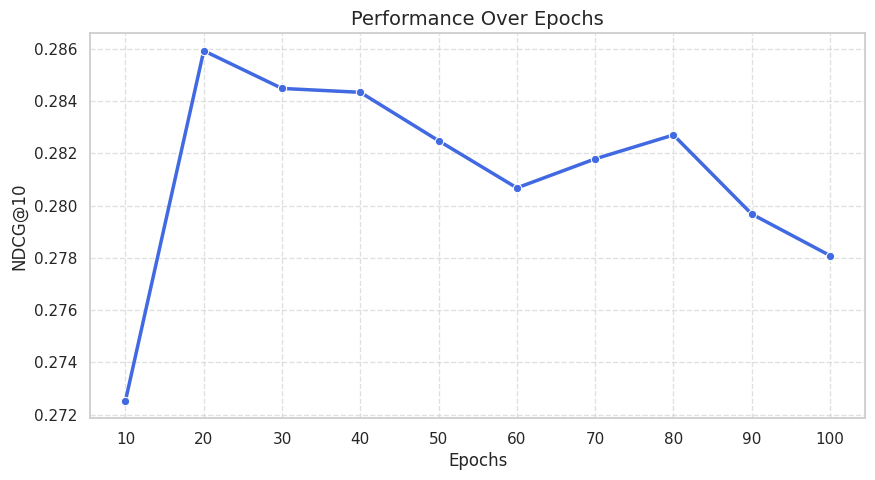

In [52]:
sns.set(style="whitegrid")

# Plot 1: Performance vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="ndcg", marker="o", linewidth=2.5, color="royalblue")
plt.title("Performance Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("NDCG@10", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

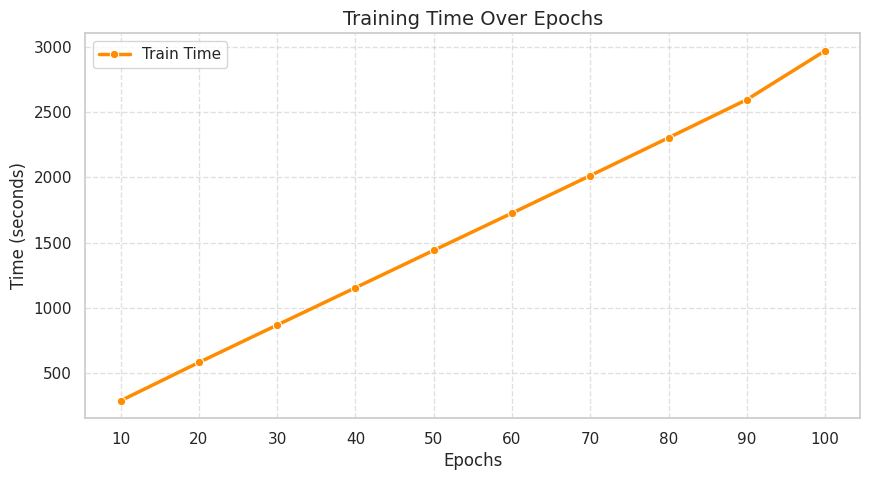

In [53]:
# Plot 2: Train Time & Prediction Time vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="train_time", marker="o", linewidth=2.5, label="Train Time", color="darkorange")
plt.title("Training Time Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()